In [1]:
 # import basic package
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

#Deal with warnings
import warnings
warnings.filterwarnings('ignore')
style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

#import my own packages
# import fraud_fun
# import myfunc_pd as mf


# from binary encoder import package 
import category_encoders as ce

#import package for ML and feature engineering
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.svm import SVC, OneClassSVM
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from imblearn.under_sampling import NearMiss
import lightgbm

# Reading Full dataset

In [11]:
train = pd.read_csv('FullData_nor_train.csv')
train.drop(columns='Unnamed: 0',inplace=True)
test = pd.read_csv('FullData_nor_test.csv')
test.drop(columns='Unnamed: 0',inplace=True)

train.shape, test.shape

((590540, 571), (506691, 570))

# Modelling based on 80% of dataset

In [12]:
training, testing = train_test_split(train,test_size=0.2, random_state=42)

# Feature Selection (chi2)

In [13]:
training.head(2)

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,id_35_NotFound,id_35_T,id_36_NotFound,id_36_T,id_37_NotFound,id_37_T,id_38_NotFound,id_38_T,DeviceType_desktop,DeviceType_mobile
5307,0.0,0.001840,0.229248,0.468,0.381679,0.919708,0.488636,0.836957,0.004083,0.019948,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
191582,0.0,0.000724,0.164808,0.392,0.648855,0.919708,0.433486,0.834789,0.011521,0.000602,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [14]:
#Create array from data values

array = training.values

#Split the data into input and target

X = array[:,1:]

Y = array[:,0]

#We will select the features using chi square

chi2_selector = SelectKBest(score_func=chi2, k=350)

#Fit the function for ranking the features by score

fit = chi2_selector.fit(X, Y)

#Summarize scores numpy.set_printoptions(precision=3) print(fit.scores_)

#Apply the transformation on to dataset

features = fit.transform(X)

#Summarize selected features print(features[0:5,:])

In [15]:
# Look at scores returned from the selector for each feature
chi2_scores = pd.DataFrame(list(zip(training.columns, chi2_selector.scores_, chi2_selector.pvalues_)), columns=['ftr', 'score', 'pval'])
chi2_scores

,ftr,score,pval
0,isFraud,1.037119,3.084924e-01
1,TransactionAmt,13.541003,2.334077e-04
2,card1,0.526851,4.679340e-01
3,card2,200.068694,2.017629e-45
4,card3,65.325831,6.348376e-16
5,card5,1.151591,2.832164e-01
6,addr1,0.228520,6.326237e-01
7,addr2,2.429117,1.190999e-01
8,dist1,0.207016,6.491161e-01
9,dist2,130.603609,3.023327e-30


In [16]:
feature_columns = [c for c in training.columns if c != 'isFraud']
new_features = []
mask = fit.get_support() #list of booleansnew_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_columns):
    if bool:
        new_features.append(feature)

training = pd.DataFrame(training[new_features], columns=new_features)
training['isFraud'] = Y

In [17]:
training.head()

,card1,card3,card5,C1,C2,C4,C5,C6,C7,C8,...,id_35_NotFound,id_35_T,id_36_NotFound,id_37_NotFound,id_37_T,id_38_NotFound,id_38_T,DeviceType_desktop,DeviceType_mobile,isFraud
5307,0.229248,0.381679,0.919708,0.000427,0.000176,0.000000,0.000000,0.000444,0.000000,0.0000,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
191582,0.164808,0.648855,0.919708,0.000213,0.000176,0.000444,0.000000,0.000444,0.000443,0.0003,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
260168,0.665498,0.381679,0.481752,0.001281,0.000879,0.000000,0.011461,0.001775,0.000000,0.0000,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
18516,0.288515,0.381679,0.919708,0.000213,0.000176,0.000444,0.000000,0.000444,0.000000,0.0006,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
47538,0.866579,0.381679,0.014599,0.000213,0.000176,0.000444,0.000000,0.000444,0.000000,0.0003,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [18]:
training.shape

(472432, 351)

# Modelling (Unsupervised ML)

In [19]:
# Reading testing (20% of Full dataset) for future testing.
target_column = 'isFraud'
feature_columns = new_features

y_ = testing[target_column].values
X_ = testing[feature_columns].values
testing.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,id_35_NotFound,id_35_T,id_36_NotFound,id_36_T,id_37_NotFound,id_37_T,id_38_NotFound,id_38_T,DeviceType_desktop,DeviceType_mobile
470624,0.0,0.022662,0.392389,0.762,0.381679,0.905109,0.652273,0.836957,0.011521,0.019948,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
565820,0.0,0.003389,0.663601,0.442,0.381679,0.919708,0.854545,0.836957,0.000000,0.019948,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
284083,0.0,0.001494,0.482870,0.022,0.381679,0.905109,0.488636,0.836957,0.000583,0.019948,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
239689,0.0,0.003142,0.855656,0.890,0.648855,0.277372,0.433486,0.834789,0.011521,0.019948,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
281855,0.0,0.003372,0.833352,0.780,0.381679,0.919708,0.452273,0.836957,0.011521,0.019948,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [20]:
y = training[target_column].values
X = training[feature_columns].values

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [21]:
X.shape

(472432, 350)

## Isolation Forest

In [22]:
from sklearn.ensemble import IsolationForest

In [23]:
iso_model = IsolationForest(n_estimators=100,behaviour='new',contamination=0.035,random_state=42)
iso_model.fit(X_train)
iso_model.fit_predict(X_train)

array([ 1,  1, -1, ...,  1,  1,  1])

[[88596  2498]
 [ 2625   768]]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     91094
         1.0       0.24      0.23      0.23      3393

    accuracy                           0.95     94487
   macro avg       0.60      0.60      0.60     94487
weighted avg       0.94      0.95      0.95     94487

0.9457809010763385


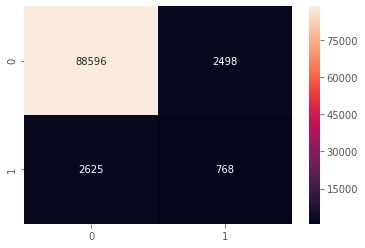

In [24]:
# Validation (80% Dataset training):
# Returns -1 for outliers and 1 for inliers.

y_pred = iso_model.predict(X_test)
# TP = 0
# FP = 0
# TN = 0
# FN = 0
for i in range(len(y_pred)):
    if y_pred[i] == 1:
        y_pred[i] = 0
    if y_pred[i] == -1:
        y_pred[i] = 1
   
            
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");

[[110744   3122]
 [  3244    998]]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    113866
         1.0       0.24      0.24      0.24      4242

    accuracy                           0.95    118108
   macro avg       0.61      0.60      0.61    118108
weighted avg       0.95      0.95      0.95    118108

0.9461001794967318


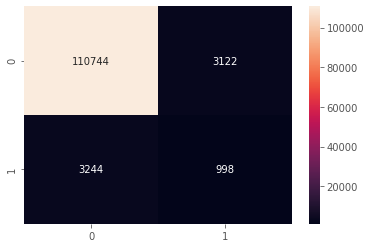

In [25]:
# For real testing (20% of training dataset):
# Returns -1 for outliers and 1 for inliers.

y_pred = iso_model.predict(X_)
# TP = 0
# FP = 0
# TN = 0
# FN = 0
for i in range(len(y_pred)):
    if y_pred[i] == 1:
        y_pred[i] = 0
    if y_pred[i] == -1:
        y_pred[i] = 1
   
            
print(confusion_matrix(y_,y_pred))
print(classification_report(y_,y_pred))
print(accuracy_score(y_, y_pred))

cm = confusion_matrix(y_, y_pred)
sns.heatmap(cm,annot=True,fmt="d");

## One-Class SVM

In [55]:
one_svm = OneClassSVM(nu=0.04, kernel="rbf",gamma=0.1)
one_svm.fit(X_train)
one_svm.fit_predict(X_train)

array([ 1, -1,  1, ...,  1,  1,  1])

[[87466  3628]
 [ 3134   259]]
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96     91094
         1.0       0.07      0.08      0.07      3393

    accuracy                           0.93     94487
   macro avg       0.52      0.52      0.52     94487
weighted avg       0.93      0.93      0.93     94487

0.92843459946871


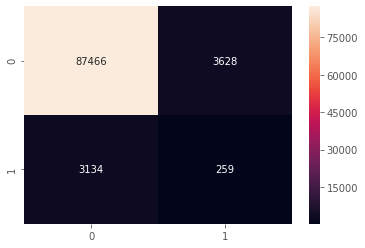

In [56]:
# Validation (80% Dataset training):
# Returns -1 for outliers and 1 for inliers.

y_pred = one_svm.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i] == 1:
        y_pred[i] = 0
    if y_pred[i] == -1:
        y_pred[i] = 1
   
            
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");

[[109357   4509]
 [  3908    334]]
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96    113866
         1.0       0.07      0.08      0.07      4242

    accuracy                           0.93    118108
   macro avg       0.52      0.52      0.52    118108
weighted avg       0.93      0.93      0.93    118108

0.9287347173773157


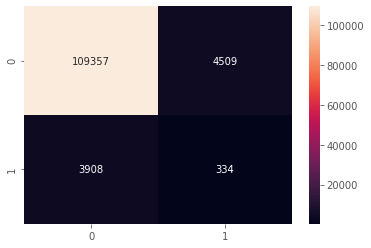

In [57]:
# For real testing:
# Returns -1 for outliers and 1 for inliers.

y_pred = one_svm.predict(X_)

for i in range(len(y_pred)):
    if y_pred[i] == 1:
        y_pred[i] = 0
    if y_pred[i] == -1:
        y_pred[i] = 1
   
            
print(confusion_matrix(y_,y_pred))
print(classification_report(y_,y_pred))
print(accuracy_score(y_, y_pred))

cm = confusion_matrix(y_, y_pred)
sns.heatmap(cm,annot=True,fmt="d");

## Robust covariance

In [58]:
from sklearn.covariance import EllipticEnvelope

[[87455  3639]
 [ 3284   109]]
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     91094
         1.0       0.03      0.03      0.03      3393

    accuracy                           0.93     94487
   macro avg       0.50      0.50      0.50     94487
weighted avg       0.93      0.93      0.93     94487

0.9267306613608222


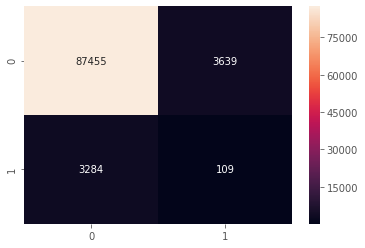

In [59]:
rob_cov = EllipticEnvelope(contamination=0.04).fit(X_train)
rob_cov.fit_predict(X_train)

# Validation (80% Dataset training):
# Returns -1 for outliers and 1 for inliers.

y_pred = rob_cov.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i] == 1:
        y_pred[i] = 0
    if y_pred[i] == -1:
        y_pred[i] = 1
   
            
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");

[[109130   4736]
 [  4107    135]]
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    113866
         1.0       0.03      0.03      0.03      4242

    accuracy                           0.93    118108
   macro avg       0.50      0.50      0.50    118108
weighted avg       0.93      0.93      0.93    118108

0.9251278490872761


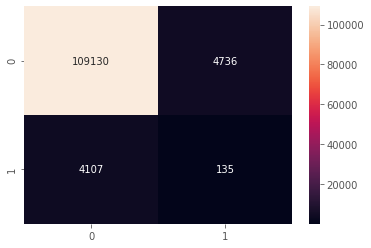

In [60]:
# For real testing:
# Returns -1 for outliers and 1 for inliers.

y_pred = rob_cov.predict(X_)

for i in range(len(y_pred)):
    if y_pred[i] == 1:
        y_pred[i] = 0
    if y_pred[i] == -1:
        y_pred[i] = 1
   
            
print(confusion_matrix(y_,y_pred))
print(classification_report(y_,y_pred))
print(accuracy_score(y_, y_pred))

cm = confusion_matrix(y_, y_pred)
sns.heatmap(cm,annot=True,fmt="d");

# Try with Oversampling

In [26]:
# Divide by class
Normal = training[training['isFraud'] == 0]
Fraud = training[training['isFraud'] == 1]

# Set-up the target and feature columns

target_column = 'isFraud'
# feature_columns = [c for c in train.columns if c != target_column]

# Pass the values into X and y
y = training[target_column]
X = training[new_features]

print(Normal.shape, Fraud.shape)
print(X.shape, y.shape)

(456011, 351) (16421, 351)
(472432, 350) (472432,)


In [27]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(ratio=1, random_state=42)
X_res, y_res = os.fit_sample(X,y)

In [28]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Oversampling dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0.0: 456011, 1.0: 16421})
Oversampling dataset shape Counter({0.0: 456011, 1.0: 456011})


In [29]:
y = y_res
X = X_res

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [30]:
iso_model = IsolationForest(n_estimators=100,behaviour='new',contamination=0.5,random_state=42)
iso_model.fit(X_train)
iso_model.fit_predict(X_train)

array([ 1,  1, -1, ...,  1, -1, -1])

[[60205 30822]
 [30742 60636]]
              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66     91027
         1.0       0.66      0.66      0.66     91378

    accuracy                           0.66    182405
   macro avg       0.66      0.66      0.66    182405
weighted avg       0.66      0.66      0.66    182405

0.6624873221677038


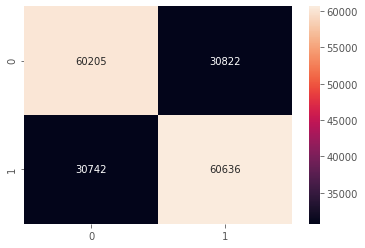

In [31]:
# Validation (80% Dataset training):
# Returns -1 for outliers and 1 for inliers.
y_pred = iso_model.predict(X_test)
# TP = 0
# FP = 0
# TN = 0
# FN = 0
for i in range(len(y_pred)):
    if y_pred[i] == 1:
        y_pred[i] = 0
    if y_pred[i] == -1:
        y_pred[i] = 1
   
            
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");

[[75577 38289]
 [ 1451  2791]]
              precision    recall  f1-score   support

         0.0       0.98      0.66      0.79    113866
         1.0       0.07      0.66      0.12      4242

    accuracy                           0.66    118108
   macro avg       0.52      0.66      0.46    118108
weighted avg       0.95      0.66      0.77    118108

0.6635282961357402


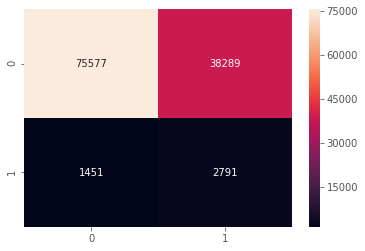

In [34]:
# For real testing:
# Returns -1 for outliers and 1 for inliers.

y_pred = iso_model.predict(X_)
# TP = 0
# FP = 0
# TN = 0
# FN = 0
for i in range(len(y_pred)):
    if y_pred[i] == 1:
        y_pred[i] = 0
    if y_pred[i] == -1:
        y_pred[i] = 1
   
            
print(confusion_matrix(y_,y_pred))
print(classification_report(y_,y_pred))
print(accuracy_score(y_, y_pred))

cm = confusion_matrix(y_, y_pred)
sns.heatmap(cm,annot=True,fmt="d");

In [33]:
# Save model iso_model
from sklearn.externals import joblib
joblib.dump(iso_model, 'iso_model.sav')

/anaconda3/envs/python/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['iso_model.sav']

# Functions

In [5]:
def binary_encoder(DataFrame, col):

    # Using the binary encoder to deal with large_col_cat:

    df = DataFrame[col]

    # Calling encoder function.
    encoder = ce.BinaryEncoder(cols=col)
    df_binary = encoder.fit_transform(df)
    return df_binary
    # Concat the features with previous dataset
#     DataFrame = pd.concat([DataFrame,df_binary],axis=1)
#     DataFrame.drop(columns=col, inplace=True)
    print(f'************** Finish binary_encoder *****************')

In [6]:
def get_dummies_label(DataFrame, col):
    # Using dummies to deal with the small amount of unique values in small_col_cat
    df_small = DataFrame[col]
    # Get dummies
    df_dummies = pd.get_dummies(df_small, prefix_sep='_', drop_first=True)
    return df_dummies
    # Concat the features with previous dataset
#     DataFrame = pd.concat([DataFrame,df_dummies],axis=1)
#     DataFrame.drop(columns=col, inplace=True)
    
    print(f'************** Finish get_dummies_label *****************')